# WARNING!!!

After pulling down the tutorial notebook, immediately make a copy. Then do not modify the original. Do your work in the copy. This will prevent the possibility of git conflicts should the version-controlled file change at any point in the future.

This notebook is adapted from the [KIPAC/StatisticalMethods course](https://github.com/KIPAC/StatisticalMethods), (c) 2019 Adam Mantz and Phil Marshall, licensed under the GPLv2.

If the following cell is confusing, read the `KIPAC/StatisticalMethods` tutorial [how-to](howto.ipynb).

In [1]:
class SolutionMissingError(Exception):
    def __init__(self):
        Exception.__init__(self,"You need to complete the solution for this code to work!")
def REPLACE_WITH_YOUR_SOLUTION():
    raise SolutionMissingError
REMOVE_THIS_LINE = REPLACE_WITH_YOUR_SOLUTION

# Tutorial: Checking and Comparing Models

## Goodness of fit, information criteria, and Bayesian evidence

## Introduction

In this tutorial we'll look at some simple, realistic, simulated data, and do some model evaluation, including

* fitting a simple model, and then do a _posterior predictive model check_ of the adequacy of the fit
* quantifying the generalized predictive accuracy of the model with the Deviance Information Criterion (DIC)
* calculating the Bayesian evidence for the model

Then you'll get to do it all again with a more complex model and determine which is preferred!

## The Dataset

Our data is just a list of numbers. Each one represents a measured distance, $y$, between two different estimates of the center of a galaxy cluster: the location of the presumed central galaxy and a centroid of the diffuse, emissive gas. The context here is that automated algorithms sometimes fail to chose the central galaxy correctly (because of image artifacts or other problems), whereas the gas centroid is more reliable but also more expensive to measure. Therefore, we'd like to use this data set to _characterize the distribution of mis-centerings_ so that the galaxy-based centers can be used for large sample, with the resulting errors propagated forward through future processing, e.g., weak lensing estimates.

Let's load up the data and have a look.

In [2]:
import numpy as np
import scipy.stats as st
from scipy.special import logsumexp
import emcee
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 16});

Load data into global variable `y`. Each entry is an offset in units of kpc.

In [4]:
y = np.loadtxt('data/model_comparison.dat')

Check out a quick histogram of the data.

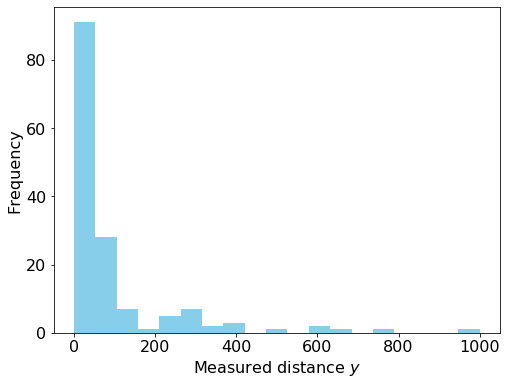

In [5]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
bins = np.linspace(0,1000,20)
plt.hist(y, bins=bins, color="skyblue");
plt.xlabel("Measured distance $y$");
plt.ylabel("Frequency");

## 1. Pre-registering a Test Statistic

The hypothesis we will test in this tutorial is the model outlined in the next section - but how well that model fits the data is a question we will answer in part using a _test statistic._ 

Having understood what the data represent (and had a quick look at them), what feature in the data do you want your model to explain well?  

With this in mind, what is a good test statistic to _summarize_ the data? Spend a few mins thinking about this and discussing it, then implement is before moving on. You'll then use this "pre-registered" test statistic in a Bayesian model check below.

Your test statistic should be a function of the data only, although in general it's also possible to use statistics that are functions of both the data and model.

In [20]:
try:
    exec(open('solutions/teststatistic.py').read())
except IOError:
    def T(yy):
        """
        Argument: a data vector (either the real data or a simulated data set)
        Returns: a scalar test statistic computed from the argument
        """
        return np.std(yy)

Compute the test statistic of the real data to verify that it works.

In [21]:
T_true = T(y)
print("The test statistic of the real data is T =", T_true)

The test statistic of the real data is T = 152.4917905110399


## Setting up a Computational Framework

Once we define a model to work with (below), we'll want to fit that model to the data, and then evaluate it using the methods we saw in the [model evaluation lesson](../lessons/modelevaluation.ipynb). These include:

* a visual check using replica datasets drawn from the posterior predictive distribution
* a quantitative posterior predictive model check using a suitable test statistic $T(y)$

After chosing and fitting a second, alternative model, we can also compare the two in terms of

* the Deviance Information Criterion (DIC), to assess the models' (relative) generalized predictive accuracy
* the Bayesian Evidence, to provide insight on the (relative) probability of each model given the data

Notice that each of these bulleted operations can be coded as a _function of the model_ (e.g. a visual check of the model, the evidence of the model, and so on). That suggests that we should write a _class_ that completely describes the model, and then a set of _functions that act on model objects passed to them._ Since we anticipate looking at multiple models, we'll use _inheritance_. While this level of object oriented programming may not be familiar, most of the details are filled in for you below.

We start by defining a _base class_, which contains the functionality common to any model we care to define later. To make it clear what functionality we expect _derived classes_ to provide, we'll include defintions of non-functional methods that the derived classes will need to _override_.

In [24]:
# This is something we can throw to discourage direct instantiation of the base class
class VirtualClassError(Exception):
    def __init__(self):
        Exception.__init__(self,"Do not directly instantiate the base Model class!")

class Model:
    """
    Base class for inference and model evaluation in a simple cluster mis-centering analysis.
    In all these functions, `args' is the ordered list of model parameters.
    """
    def __init__(self):
        """
        Note: derived classes should have their own __init__ function which ends by calling this one
        """
        # Sometimes it will be convenient to compute many log_likelihood values at once:
        self.vectorized_log_likelihood = np.vectorize(self.log_likelihood)
        self.samples = None
        self.Nsamples = 0
  
    def log_prior(self, *args):
        """
        Evaluate the log prior PDF P(args|H)
        """
        raise VirtualClassError # to be overriden by child classes

    def draw_samples_from_prior(self, N):
        """
        Return N samples from the prior PDF P(args|H)
        """
        raise VirtualClassError # to be overriden by child classes

    def log_likelihood(self, *args):
        """
        Evaluate the log of the likelihood function L(args) = P(y|args,H)
        """
        raise VirtualClassError # to be overriden by child classes
    
    def sampling_distribution(self, yy, *args):
        """
        Evaluate the sampling distribution P(yy|args,H) at a point in data space yy given parameter(s) args
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        raise VirtualClassError # to be overriden by child classes 
        
    def generate_replica_dataset(self, *args):
        """
        Draw a replica dataset y_rep from the sampling distribution P(y_rep|args,H).
        y_rep should have the same length as the true data set.
        """
        raise VirtualClassError # to be overriden by child classes
        
    def log_posterior(self, *args):
        """
        Evaluate the log of the (unnormalized) posterior PDF P(args|y,H)
        
        Note: We'll use this with an MCMC sampler, so it should call the non-vectorized likelihood.
        """
        lnp = self.log_prior(*args)
        if lnp != -np.inf:
            lnp += self.log_likelihood(*args)
        return lnp

    def draw_samples_from_posterior(self, guess=None, nwalkers=None, nsteps=None, burn=None, thinby=None):
        """
        Use emcee to draw samples from P(args|y,H)
        """
        # Deal with unset inputs:
        if guess is None: print("You need to specify a starting point in parameter space with the `guess=` kwarg...")
        if nwalkers is None: print("You need to specify the `nwalkers=` kwarg...")
        if nsteps is None: print("You need to specify the chain length `nsteps=` kwarg...")
        if burn is None: print("You need to specify the length of burnin `burn=` kwarg...")
        if thinby is None: print("You need to specify the thinning factor `thinby=` kwarg...")
      
        # The density to sample is this model's own posterior PDF
        lnprob = self.log_posterior
        npars = len(guess)
        
        self.sampler = emcee.EnsembleSampler(nwalkers, npars, lnprob) 
        # You could add e.g. threads=4 to speed things up with multiprocessing
        
        # Generate an ensemble of walkers within +/-1% of the guess:
        theta_0 = np.array([guess*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
        # Note that the initial parameter array theta_0 should have dimensions nwalkers × npars
        
        # Evolve the ensemble:
        self.sampler.run_mcmc(theta_0, nsteps)
        
        # Plot the raw samples:
        plt.rcParams['figure.figsize'] = (12.0, 6.0)
        plt.subplot(211)
        for j in range(nwalkers): 
            plt.plot(self.sampler.chain[j,:,0], 'o', alpha=0.2)
        plt.title("Raw Markov chains")
            
        # Extract the chain, remove burnin, merge, and thin:
        samples = self.sampler.chain[:, burn:, :].reshape((-1, npars))
        samples = samples[range(0,samples.shape[0],thinby),:]
        
        # Keep the samples with the model for future use!
        self.samples = samples
        self.Nsamples = len(samples)
        
        # Plot the thinned chain
        plt.subplot(212)
        plt.plot(samples[:,0], 'o')
        plt.title("Thinned, post-burnin chains");

## 2. Evaluating a Simple Model

First, let's assume a simple model $H_1$, that the sampling distribution is an exponential:

**Model 1:** $P(y|a_1, H_1) = \frac{1}{a_1}e^{-y/a_1}$; $y\geq0$

Our single parameter is $a_1$, the mean of the exponential distribution.

### 2a. Implementation in code

Complete the implementation of this model as a derived class of `Model`, below. Note than an `ExponentialModel` object still has all the methods defined for `Model`, in particular the ones that we _don't_ need to redefine here.

Note that this includes choosing a reasonable prior for $a_1$. It should be a proper (normalizable) distribution. We don't want to deal with improper distributions when calculating the evidence later on.

Make sure you understand the workings of even the functions that are completely given.

In [34]:
try:
    exec(open('solutions/exponentialmodel.py').read())
except IOError:

    class ExponentialModel(Model):
        """
        Simple exponential model for mis-centering.
        """
        def __init__(self):
            # Define any hyperparameters for the a1 prior here.
            # E.g., for uniform, something like "self.min_a1 = value" and "self.max_a1 = value"
            # More sophisticatedly, you could make these values arguments of __init__.
            self.min_a1 = 0
            self.max_a1 = 1000
            # The next line finishes initialization by calling the parent class' __init__
            Model.__init__(self)

        def log_prior(self, a1):
            """
            Evaluate the log prior PDF P(a1|H)
            """
            if self.min_a1 < a1 < self.max_a1:
                return 1/np.abs(self.max_a1 - self.min_a1)
            else:
                return -np.inf

        def draw_samples_from_prior(self, N):
            """
            Return N samples of a1 from the prior PDF P(a1|H)
            """
            return np.random.random(N)*(self.max_a1-self.min_a1)+self.min_a1

        def log_likelihood(self, a1):
            """
            Evaluate the log of the likelihood function L(a1) = P(y|a1,H)
            Argument a1 is scalar.
            """
            return np.sum(st.expon.logpdf(y, scale=a1))

        def sampling_distribution(self, yy, a1):
            """
            Evaluate the sampling distribution P(yy|a,H) at a point in data space yy given parameter value a1
            We expect a vector input yy, and return the corresponding probabilities.
            
            Note: This is useful for making plots of "the model" overlaid on the histogram of the data
            """
            return st.expon.pdf(yy, scale=a1)

        def generate_replica_dataset(self, a1):
            """
            Draw a replica data set y_rep from the sampling distribution P(y_rep|a1,H).
            y_rep should have the same length as the true data set.
            Argument a1 is a scalar.
            """
            return st.expon.rvs(size=len(y), scale=a1)
            

Now try instantiating a model and drawing a dozen samples from its prior as a test:

In [35]:
Model1 = ExponentialModel()
print("12 sample values drawn from the prior of Model1: ", Model1.draw_samples_from_prior(12))

12 sample values drawn from the prior of Model1:  [348.77170602 969.53355866 809.43950004 475.00749154 793.31037495
 562.62696244 150.97866018 443.44618432 311.54799569  69.18524763
 552.40259045 155.55523345]


Test out the log-posterior function to make sure it's not obviously buggy.

In [36]:
for a1 in [1.0, 10.0, 100.0, -3.14]:
    print('Log-posterior for a1=', a1, ' = ', Model1.log_posterior(a1))

Log-posterior for a1= 1.0  =  -14238.7904788
Log-posterior for a1= 10.0  =  -1769.2659118291072
Log-posterior for a1= 100.0  =  -833.1624426862138
Log-posterior for a1= -3.14  =  -inf


Similarly the mock-data producing function (with an arbitrary $a_1$ value).

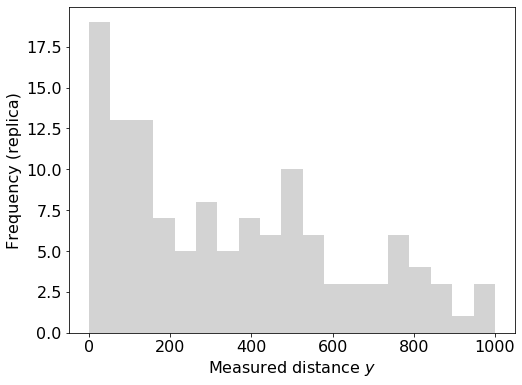

In [37]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.hist(Model1.generate_replica_dataset(500.), bins=bins, color="lightgray");
plt.xlabel("Measured distance $y$");
plt.ylabel("Frequency (replica)");

Finally, test the sampling distribution function.

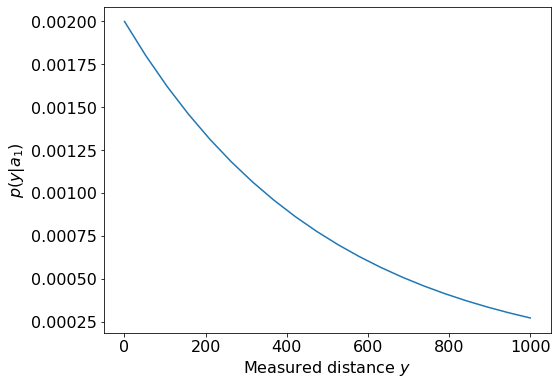

In [39]:
plt.plot(bins, Model1.sampling_distribution(bins, 500.));
plt.xlabel("Measured distance $y$");
plt.ylabel("$p(y|a_1)$");

### 2b. Fit the model to the data

The `draw_samples_from_posterior` method carries out a parameter inference with `emcee`, displaying its Markov chains, removing burn-in, thinning, and concatenating the chains. Since this step isn't really the point of this problem, the code is given to you, but you'll still need to experiment with the keyword argument ("kwarg") inputs (and read the code to see what they do) in order to get good results. (The suggestions in the cell below are pretty terrible.)

As a rule, you should start with `burn=0` and `thinby=1`, and set these appropriately for a final run once you know what the time to convergence and autocorrelation roughly are.

The MCMC samples are stored in the `Model.samples` array.

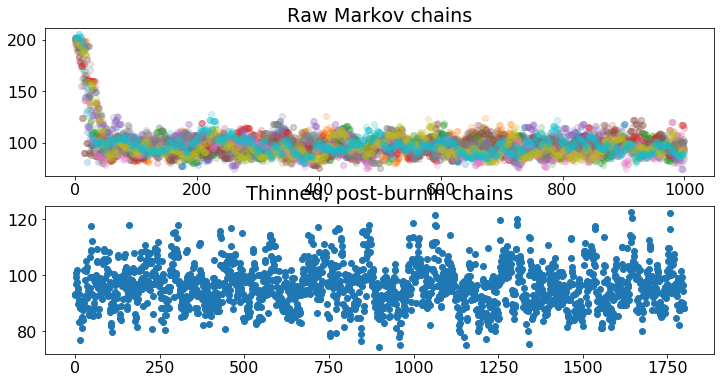

In [43]:
try:
    exec(open('solutions/fit.py').read())
except IOError:
    # This will execute out of the box, but will not work well. The arguments should be fiddled with.
    Model1.draw_samples_from_posterior(guess=[200.0], nwalkers=10, nsteps=1000, burn=100, thinby=5)

It will be useful for later to know the mean of the posterior:

In [44]:
Model1.post_mean = np.mean(Model1.samples, axis=0)
print("Posterior mean value of a1 = ", Model1.post_mean)

Posterior mean value of a1 =  [96.26867607]


### 2c. Visually compare the posterior predictions with the data.

First, let's just plot the posterior-mean model over the data.

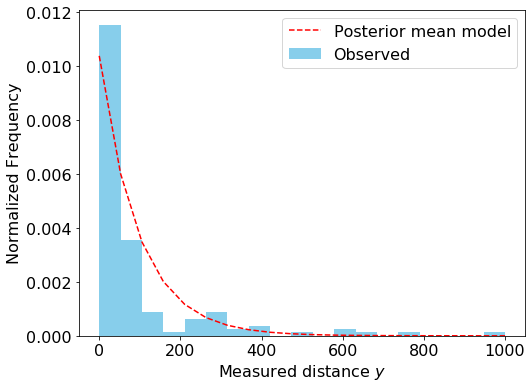

In [45]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

# First the histogram of observed data, as backdrop:
plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed")

# Now overlay a curve following the sampling distribution conditioned on the posterior mean value of a1: 
pp = Model1.sampling_distribution(bins, Model1.post_mean)
plt.plot(bins, pp, linestyle="dashed", color="red", label="Posterior mean model")

plt.xlabel("Measured distance $y$")
plt.ylabel("Normalized Frequency")
plt.legend();

This kind of plot should be familiar: it's often a good idea to evaluate model adequacy in data space. You should already be able to see telling differences between the a well-fitting model's sampling distribution, and the data histogram.

Now, let's compare a random predicted ("replica") data set, drawn from the _posterior predictive distribution,_ with the data. To do this we first draw a parameter value from the posterior PDF, and then generate a dataset from the sampling distribution conditioned on that value. The result is a sample from $P(y_{rep}|y)$.

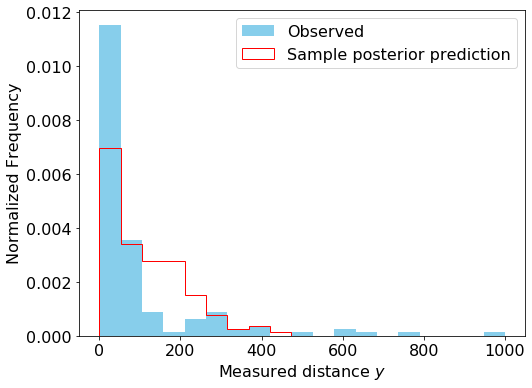

In [46]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

# First the histogram of observed data, as backdrop:
plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed")

# Choose a posterior sample at random and generate a replica dataset, and show its histogram
j = np.random.randint(0, len(Model1.samples))
mock = Model1.generate_replica_dataset(Model1.samples[j])
plt.hist(mock, bins=bins, alpha=1.0, histtype="step", color="red", density=True, label="Sample posterior prediction")

plt.xlabel("Measured distance $y$")
plt.ylabel("Normalized Frequency")
plt.legend();

This plot is nice because it is comparing apples with apples: do mock datasets drawn from our model sampling distribution with any plausible parameter value "look like" the real data?

To best evaluate this, we want to visualize the posterior predictive distribution of replica datasets. We can do this by plotting many replica datasets drawn from the posterior predictive PDF, e.g. _one for each of our posterior samples_. Let's put this plot in a function, so we can re-use it later.

In [47]:
def visual_check(Model, Nreps=None):
    plt.rcParams['figure.figsize'] = (8.0, 6.0)

    # First the histogram of observed data, as backdrop:
    plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed")

    # Compute the posterior mean parameter (vector)
    pm = np.mean(Model.samples, axis=0)

    # Make a large number of replica datasets, and overlay histograms of them all 
    if Nreps is None: Nreps = len(Model.samples)
    alpha = 5.0 / Nreps
    for jj in np.round(np.linspace(0, len(Model.samples), num=Nreps, endpoint=False)): 
        j = int(jj)
        if j==0:  
            # Plot a dataset drawn using a = the posterior mean a, to give a good legend
            mock = Model.generate_replica_dataset(pm)
            plt.hist(mock, bins=bins, histtype="step", alpha=1.0, color="red", density=True, label="Sample posterior predictions")
        else:     
            # Take the next posterior sample a and generate a replica dataset
            mock = Model1.generate_replica_dataset(Model.samples[j])
            plt.hist(mock, bins=bins, histtype="step", alpha=alpha, color="red", density=True)

    # Include the posterior mean model for comparison
    pp = Model1.sampling_distribution(bins, pm)
    plt.plot(bins, pp, linestyle="dashed", color="red", label="Posterior mean model")

    plt.xlabel("Measured distance $y$")
    plt.ylabel("Normalized Frequency")
    plt.legend();

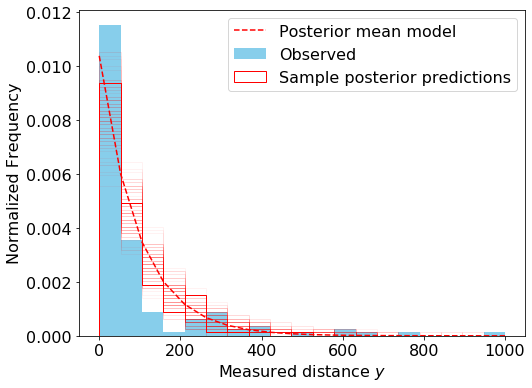

In [48]:
visual_check(Model1, Nreps=100)

Based on these visual checks, would you say the model does a good job of predicting the observed data?

### 2c. Quantitative posterior predictive model check

Now let's quantify the (in)adequacy of the fit with a quantitative _posterior predictive model check_, based on the `test_statistic` function you've already defined.

To sample the posterior predictive distribution of test statistics $P(T(y_{rep})|y)$, we need to generate replica datasets from the model:

In [49]:
def distribution_of_T(Model):
    """
    Compute T(yrep) for each yrep drawn from the posterior predictive distribution,
    using parameter samples stored in Model.
    """
    return np.array([T(Model.generate_replica_dataset(a)) for a in Model.samples])

We can now do the following:
* plot a histogram of $T(\mathrm{mock~data})$
* compare that distribution with $T(\mathrm{real~data})$
* compute and report the p-value for $T(\mathrm{real~data})$

And we want all of that in packaged in functions of the model, so that we can re-use it later (on different models!). 

First let's write a function to compute the p-value, $P(T > T(y)|y,H)$:

In [ ]:
try:
    exec(open('solutions/pvalue.py').read())
except IOError:
    def pvalue(Model):
        """
        Compute the posterior predictive p-value, P(T > T(y)|y,H):
        """
        TT = distribution_of_T(Model)
        p = 
        return p

Here's a function that plots the distribution of T, and reports the p-value:

In [50]:
def posterior_predictive_check(Model, nbins=25):
    """
    Compute the posterior predictive distribution of the test statistic T(y_rep), and compare with T(y_obs) 
    """
    # Compute distribution of T(yrep):
    TT = distribution_of_T(Model)
    
    # Plot:
    plt.rcParams['figure.figsize'] = (8.0, 6.0)
    plt.hist(TT, bins=nbins, histtype="step", color="red", label="$P(T(y_{\\rm rep})|y)$")
    
    # Overlay T(y_obs):
    plt.axvline(x=T(y), color="gray", linestyle="dashed", label="$T(y_{\\rm observed})$")
    plt.xlabel("Test statistic T(y)")
    plt.ylabel("Posterior predictive probability density")
    plt.legend();
    
    # Compute p-value:
    p = pvalue(Model)
    print("p-value =", p)

    return p

NameError: name 'pvalue' is not defined

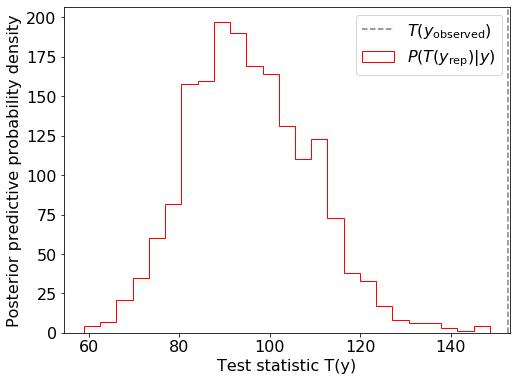

In [51]:
p1 = posterior_predictive_check(Model1)

Does this result agree with your visual evaluation of the model fitness from the last section? If not, perhaps the test statistic you chose doesn't reflect the agreement you're looking for when inspecting the posterior predictions. If you'd like to re-define your test statistic, do so now and repeat this check.

#### 6. Calculate the DIC for Model 1.

We saw in class that the Deviance Information Criterion is given by:

$\mathrm{DIC} = \langle D(\theta) \rangle + p_D; \quad p_D = \langle D(\theta) \rangle - D(\langle\theta\rangle)$

where the deviance $D(\theta)=-2\log P(\mathrm{data}|\theta)$, and averages $\langle\rangle$ are over the posterior.

Write this function, and execute it for the simple model. 

In [ ]:
try:
    exec(open('solutions/dic.py').read())
except IOError:
    REMOVE_THIS_LINE()
    def DIC(Model):
        """
        Compute the Deviance Information Criterion for the given model
        """
        # Compute the deviance D for each sample, using the vectorized code.
        D = -2.0*Model.vectorized_log_likelihood(Model.samples)
        pD = REPLACE_WITH_YOUR_SOLUTION()
        DIC = REPLACE_WITH_YOUR_SOLUTION()
        return DIC, pD

In [ ]:
DIC1, pD1 = DIC(Model1)
print("Effective number of fitted parameters =", pD1)
print("DIC =", DIC1)

Does your value of $p_D$ make intuitive sense?

### 2d. Compute the evidence

To do this, note that

$P(D|H)=\int P(D|\theta,H) \, P(\theta|H) d\theta$

can be approximated by an average over samples from the prior

$P(D|H) \approx \frac{1}{m}\sum_{k=1}^m P(D|\theta_k,H)$; $\theta_k\sim P(\theta|H)$.

This estimate is better than trying to use samples from the posterior to calculate the evidence, if only because it's unbiased. But in general, and especially for large-dimensional parameter spaces, it is very inefficient (because the likelihood typically is large in only a small fraction of the prior volume). Still, it will do for this exercise.

In a function, draw a large number of samples from the prior and use them to calculate the evidence. To avoid numerical over/underflows, use the special `scipy` function `logsumexp` (which we imported directly, way at the top of the notebook) to do the sum. As the name implies, this function is equivalent to `log(sum(exp(...)))`, but is more numerically stable.

In [ ]:
try:
    exec(open('solutions/evidence.py').read())
except IOError:
    REMOVE_THIS_LINE()
    def log_evidence(Model, N=1000):
        """
        Compute the log evidence for the model using N samples from the prior
        """
        REPLACE_WITH_YOUR_SOLUTION()

Roughly how precisely do we need to know the log Evidence, to be able to compare models? Run `log_evidence` with different values of `N` (the number of prior samples in the average) to until you're satisfied that you're getting a usefully accurate result.

In [ ]:
for Nevidence in [1, 10, 100]: # You *will* want to change these values
    %time logE1 = log_evidence(Model1, N=Nevidence)
    print("From", Nevidence, "samples, the log-evidence is", logE1, "\n")

### Summary

We now have a lot of useful machinery for evaluating models for our data. We can do both visual and quantitative posterior predictive model checks to assess the adequacy of the model fit, and we can compute (or at least approximate) the DIC and the Bayesian evidence for the model.

The latter 2 are really only useful in the context of comparing with an alternative model, however. To see them shine, you'll need to continue on to the challenge problem.

## Challenge Problem 1

Propose an alternative model for the data, including appropriate priors, and repeat the analysis in section 2:
* implement the model,
* fit it,
* do visual and quantitative comparisons with the data,
* compute the DIC and evidence.

Then compare the DIC values and the evidence values of the two models. Is one strongly prefered over the other, and does this preference (or lack thereof) agree with your intuition given the visual model checks?

## Challenge Problem 2

As already mentioned, the naive approach to calculating the evidence used above is not a good one to use in general (especially as the number of model parameters increases). Repeat the evidence calculation using a package specifically designed to deal with this challenge, such as [`dynesty`](https://dynesty.readthedocs.io/en/latest/). Compare with the results of the simple calculation above.

(Author note: we haven't actually tried to use `dynesty` before, so if you get it to work please send us your notebook to look at!)